In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import numpy as numpy

In [2]:
image_size=256
batch_size=32

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset",
    shuffle = True,
    image_size=(image_size,image_size),
    batch_size=batch_size
)

Found 3171 files belonging to 4 classes.


In [4]:
len(dataset)

100

In [5]:
class_names=dataset.class_names
class_names

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy']

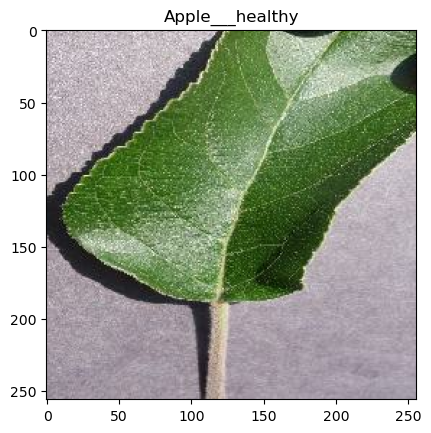

<Figure size 1000x1000 with 0 Axes>

In [6]:
for images,labels in dataset.take(1):

    image_1 = images[0].numpy().astype("uint8")

    plt.imshow(image_1)
    plt.title(class_names[labels[0]])
    plt.figure(figsize=(10,10))
    plt.show()

In [7]:
train_size = 0.8
len(dataset)*train_size

80.0

In [8]:
train_ds = dataset.take(80)

In [9]:
test_ds = dataset.skip(80)
len(test_ds)

20

In [10]:
val_size = 0.1
len(dataset)*val_size

10.0

In [11]:
val_ds = test_ds.take(10)

In [12]:
test_ds = test_ds.skip(10)
len(test_ds)

10

In [13]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [14]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [15]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [16]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(image_size,image_size),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [17]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [18]:
input_shape = (batch_size, image_size, image_size, 3)
n_classes= 4

In [19]:
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu',input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax')
])

model.build(input_shape=input_shape)

In [20]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [21]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [22]:
history = model.fit(
    train_ds,
    epochs=50,
    batch_size=batch_size,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50


80/80 [==============================] - 167s 2s/step - loss: 1.1022 - accuracy: 0.5373 - val_loss: 0.9115 - val_accuracy: 0.5808
Epoch 2/50
80/80 [==============================] - 167s 2s/step - loss: 0.7990 - accuracy: 0.6729 - val_loss: 0.6799 - val_accuracy: 0.7148
Epoch 3/50
80/80 [==============================] - 136s 2s/step - loss: 0.5512 - accuracy: 0.7859 - val_loss: 0.6551 - val_accuracy: 0.7869
Epoch 4/50
80/80 [==============================] - 130s 2s/step - loss: 0.4210 - accuracy: 0.8313 - val_loss: 0.6975 - val_accuracy: 0.7663
Epoch 5/50
80/80 [==============================] - 123s 2s/step - loss: 0.2892 - accuracy: 0.8945 - val_loss: 0.4062 - val_accuracy: 0.8591
Epoch 6/50
80/80 [==============================] - 129s 2s/step - loss: 0.3157 - accuracy: 0.8850 - val_loss: 0.3336 - val_accuracy: 0.8591
Epoch 7/50
80/80 [==============================] - 122s 2s/step - loss: 0.2789 - accuracy: 0.8957 - val_loss: 0.2428 - val_accuracy: 0.8935
Epoch 8/50


In [23]:
model.evaluate(test_ds)

10/10 [==============================] - 22s 743ms/step - loss: 0.0358 - accuracy: 0.9875


[0.03577703610062599, 0.987500011920929]

In [24]:
history

In [25]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [26]:
history.history['accuracy']

[0.5373370051383972,
 0.6728565692901611,
 0.7858554124832153,
 0.8312919735908508,
 0.8945081233978271,
 0.885025680065155,
 0.8956934213638306,
 0.9162386655807495,
 0.9237455725669861,
 0.9284867644309998,
 0.9403398036956787,
 0.9383642673492432,
 0.9276965856552124,
 0.9284867644309998,
 0.958514392375946,
 0.9569340348243713,
 0.9596997499465942,
 0.9699723720550537,
 0.9762939810752869,
 0.9672066569328308,
 0.9652311205863953,
 0.9739233255386353,
 0.979059636592865,
 0.970367431640625,
 0.9861714839935303,
 0.9711576700210571,
 0.9719478487968445,
 0.9830106496810913,
 0.9841959476470947,
 0.9901224970817566,
 0.9873567819595337,
 0.9802449345588684,
 0.9782694578170776,
 0.9905175566673279,
 0.9743184447288513,
 0.9873567819595337,
 0.9893322587013245,
 0.988146960735321,
 0.99130779504776,
 0.9782694578170776,
 0.9762939810752869,
 0.9897273778915405,
 0.99130779504776,
 0.9976294040679932,
 0.9932832717895508,
 0.9751086235046387,
 0.9849861860275269,
 0.98261559009552,
 0.

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

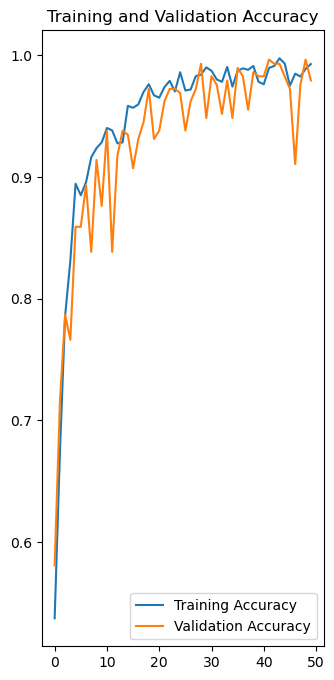

In [28]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(50),acc,label='Training Accuracy')
plt.plot(range(50),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

In [30]:

model.save("model")

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets
